In [1]:
%matplotlib inline

import numpy as np
from pprint import pprint

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torchvision
from torchvision import models, datasets, transforms
torch.manual_seed(50)

print(torch.__version__, torchvision.__version__)

2.2.2+cpu 0.17.2+cpu


In [2]:
dst = datasets.CIFAR10("~/.torch", download=True)
print("CIFAR.... PREPROCESSING")
tp = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor()
])
tt = transforms.ToPILImage()

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print("Running on %s" % device)


def label_to_onehot(target, num_classes=10):
    print("label_to_onehot")
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

Files already downloaded and verified
CIFAR.... PREPROCESSING
Running on cpu


In [3]:
def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)
    
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(768, 10),
            #act(),
            #nn.Linear(256, 10)
        )
        
    def forward(self, x):
        out = self.body(x)
        feature = out.view(out.size(0), -1)
        #print(feature.size())
        out = self.fc(feature)
        return out, feature
    
net = LeNet().to(device)
    
net.apply(weights_init)
criterion = cross_entropy_for_onehot

In [4]:
######### honest partipant #########
img_index = 25
gt_data = tp(dst[img_index][0]).to(device)
gt_data = gt_data.view(1, *gt_data.size())
gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
gt_label = gt_label.view(1, )
gt_onehot_label = label_to_onehot(gt_label, num_classes=10)


label_to_onehot


In [5]:

gt_data.requires_grad = True


In [6]:
tensor_image = gt_data[0].cpu()  # Move tensor to CPU if it's on GPU



Text(0.5, 1.0, 'Ground truth image')

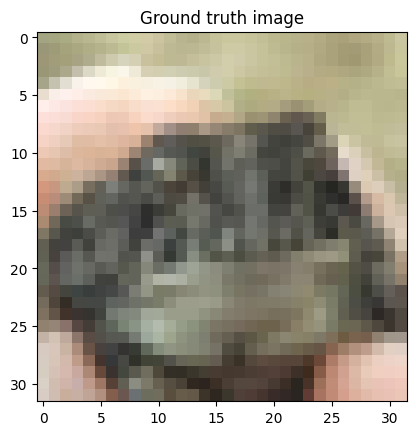

In [7]:

plt.imshow(tt(gt_data[0].cpu()))
plt.title("Ground truth image")

In [8]:

print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." % torch.argmax(gt_onehot_label, dim=-1).item())



# compute ||dr/dX||/||r|| 
out, feature_fc1_graph = net(gt_data)
deviation_f1_target = torch.zeros_like(feature_fc1_graph)
deviation_f1_x_norm = torch.zeros_like(feature_fc1_graph)

GT label is 6. 
Onehot label is 6.


760.0


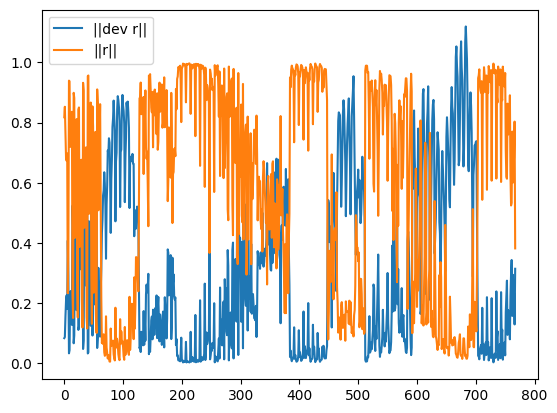

In [9]:


for f in range(deviation_f1_x_norm.size(1)):
    deviation_f1_target[:,f] = 1
    feature_fc1_graph.backward(deviation_f1_target, retain_graph=True)
    deviation_f1_x = gt_data.grad.data
    deviation_f1_x_norm[:,f] = torch.norm(deviation_f1_x.view(deviation_f1_x.size(0), -1), dim=1)/(feature_fc1_graph.data[:,f])
    net.zero_grad()
    gt_data.grad.data.zero_()
    deviation_f1_target[:,f] = 0


# prune r_i corresponding to smallest ||dr_i/dX||/||r_i||
deviation_f1_x_norm_sum = deviation_f1_x_norm.sum(axis=0)
thresh = np.percentile(deviation_f1_x_norm_sum.flatten().cpu().numpy(), 1)
mask = np.where(abs(deviation_f1_x_norm_sum.cpu()) < thresh, 0, 1).astype(np.float32)
print(sum(mask))

y = criterion(out, gt_onehot_label)
dy_dx = torch.autograd.grad(y, net.parameters())



#print(dy_dx[4].shape)


# share the gradients with other clients
original_dy_dx = list((_.detach().clone() for _ in dy_dx))
# comment this line if you want to try other defense baselines
original_dy_dx[8] = original_dy_dx[8] * torch.Tensor(mask).to(device)

# uncommnet this if you want to try model compression defense strategy

# model compression
for i in range(len(original_dy_dx)):
  grad_tensor = original_dy_dx[i].cpu().numpy()
  flattened_weights = np.abs(grad_tensor.flatten())
  # Generate the pruning threshold according to 'prune by percentage'. (Your code: 1 Line) 
  thresh = np.percentile(flattened_weights, 10)
  grad_tensor = np.where(abs(grad_tensor) < thresh, 0, grad_tensor)
  original_dy_dx[i] = torch.Tensor(grad_tensor).to(device)


# uncommnet this if you want to try differential privacy defense strategy

# differential privacy
for i in range(len(original_dy_dx)):
  grad_tensor = original_dy_dx[i].cpu().numpy()
  noise = np.random.laplace(0,1e-1, size=grad_tensor.shape)
  grad_tensor = grad_tensor + noise
  original_dy_dx[i] = torch.Tensor(grad_tensor).to(device)


plt.figure()
plt.plot(deviation_f1_x_norm_sum.cpu().numpy(), label='||dev r||')
plt.plot(feature_fc1_graph.cpu().detach().numpy().flatten(), label='||r||')
plt.legend()
plt.show()

In [10]:
# generate dummy data and label
dummy_data_init = torch.randn(gt_data.size())
dummy_label_init = torch.randn(gt_onehot_label.size())

Dummy label is 3.


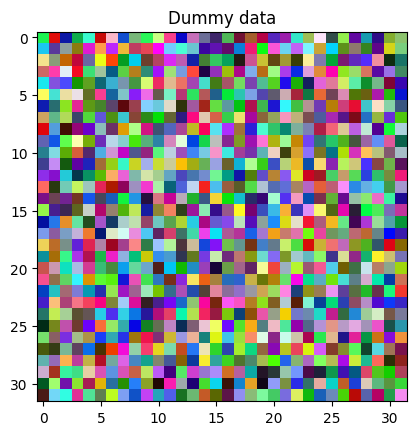

In [11]:
# generate dummy data and label
dummy_data = torch.Tensor(dummy_data_init).to(device).requires_grad_(True)
dummy_label = torch.Tensor(dummy_label_init).to(device).requires_grad_(True)

plt.imshow(tt(dummy_data[0].cpu()))
plt.title("Dummy data")
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

In [12]:
#optimizer = torch.optim.LBFGS([dummy_data, dummy_label] )
optimizer = torch.optim.SGD([dummy_data, dummy_label], lr=0.1, momentum=0.9 )

history = []
MSE_min = 100
for iters in range(300):
    def closure():
        optimizer.zero_grad()
        #out, [feature_fc1_graph, feature_fc2_graph, feature_fc3_graph] = net(gt_data)
        pred, f1 = net(dummy_data) 
        dummy_onehot_label = F.softmax(dummy_label, dim=-1)
        dummy_loss = criterion(pred, dummy_onehot_label) # TODO: fix the gt_label to dummy_label in both code and slides.
        dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
        
        grad_diff = 0
        grad_count = 0
        
        i = 0
        for gx, gy in zip(dummy_dy_dx, original_dy_dx): # TODO: fix the variablas here
            if i <=100:
              grad_diff += ((gx - gy) ** 2).sum()
              grad_count += gx.nelement()
            i += 1
        #grad_diff = grad_diff / grad_count * 1000
        
        #grad_diff = ((feature_fc1_graph - f1) ** 2).sum()
        grad_diff.backward()
        
        return grad_diff
    
    optimizer.step(closure)
    if MSE_min > (gt_data[0] - dummy_data[0]).pow(2).mean().item():
      MSE_min = (gt_data[0] - dummy_data[0]).pow(2).mean().item()
    if iters % 10 == 0: 
        current_loss = closure()
        print("{}, loss: {}, MSE: {}, MSE_min: {}".format(iters, current_loss.item(), (gt_data[0] - dummy_data[0]).pow(2).mean().item(), MSE_min))
    history.append(tt(dummy_data[0].cpu()))

0, loss: 544.68359375, MSE: 1.3205066919326782, MSE_min: 1.3205066919326782
10, loss: 511.15673828125, MSE: 1.487478256225586, MSE_min: 1.314437747001648
20, loss: 454.35986328125, MSE: 2.11438250541687, MSE_min: 1.314437747001648
30, loss: 425.0861511230469, MSE: 2.5650217533111572, MSE_min: 1.314437747001648
40, loss: 413.0082702636719, MSE: 2.7929904460906982, MSE_min: 1.314437747001648
50, loss: 407.08758544921875, MSE: 2.8868415355682373, MSE_min: 1.314437747001648
60, loss: 401.6816711425781, MSE: 2.928164482116699, MSE_min: 1.314437747001648
70, loss: 397.322509765625, MSE: 2.9557244777679443, MSE_min: 1.314437747001648
80, loss: 393.9601745605469, MSE: 2.9799559116363525, MSE_min: 1.314437747001648
90, loss: 391.0994567871094, MSE: 3.0042312145233154, MSE_min: 1.314437747001648
100, loss: 388.6101379394531, MSE: 3.03122878074646, MSE_min: 1.314437747001648
110, loss: 386.5487060546875, MSE: 3.061331033706665, MSE_min: 1.314437747001648
120, loss: 384.8167724609375, MSE: 3.09279